# Clustering Trips

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

## Feature Preparation

In [2]:
trips_df = pd.read_pickle('../00_data/trips.pkl')
trips_df.head(2)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,...,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end
0,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,0 days 00:32:00,34.05194,...,80,28,2,4,0,67,51,0,4,4
1,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,05860,Walk-up,Main & 1st,Broadway & 9th,0 days 00:30:00,34.05194,...,80,28,2,4,0,67,51,0,4,4


In [3]:
trips_hourly_df = pd.read_pickle('../00_data/trips_hourly_selected.pkl')
trips_hourly_df.head(2)

,starting_trips,ongoing_trips_prev,available_bikes,min_temp,hour,month,is_weekday,is_holiday
index,,,,,,,,
2019-01-01 01:00:00,8.0,2.0,870.0,15.6,1,1,True,True
2019-01-01 02:00:00,11.0,4.0,868.0,15.0,2,1,True,True


Let's merge the hourly data to our trip dataframe. To do that we have to have a column that has the same values as the hourly-data index.

In [4]:
trips_df["start_time_floored"] = trips_df["start_time"].dt.floor("H")
trips_df = trips_df.sort_values("start_time")
len_before_merge = len(trips_df)
trips_df = trips_df.merge(
    trips_hourly_df, left_on="start_time_floored", right_index=True
)
trips_df.head(2)


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,...,sports_poi_end,start_time_floored,starting_trips,ongoing_trips_prev,available_bikes,min_temp,hour,month,is_weekday,is_holiday
210759,2019-01-01 01:29:00,2019-01-01 02:49:00,4211,4211,12244,Walk-up,Pacific & North Venice,Pacific & North Venice,0 days 01:20:00,33.98493,...,0,2019-01-01 01:00:00,8.0,2.0,870.0,15.6,1,1,True,True
210760,2019-01-01 01:31:00,2019-01-01 02:49:00,4211,4211,05918,Walk-up,Pacific & North Venice,Pacific & North Venice,0 days 01:18:00,33.98493,...,0,2019-01-01 01:00:00,8.0,2.0,870.0,15.6,1,1,True,True


Now we can compute how many rows we lost:

In [5]:
print(len_before_merge - len(trips_df))

12020


Those 14 trips were started between 0:00 am and 1:00 am at the first of january 2019. For this hour there is no hourly
data created so it was dropped when merging.  

Now we will edit some columns to our needs:
- set the duration in minutes
- set an end hour
- change boolean values to 1 and 0
- change user types to numbers


In [6]:
trips_df["duration"] = trips_df["duration"].dt.seconds / 60
trips_df["hour_end"] = trips_df["end_time"].dt.hour
trips_df["is_weekday"] = trips_df["is_weekday"].apply(lambda x: int(x))
trips_df["is_holiday"] = trips_df["is_holiday"].apply(lambda x: int(x))
types = [
    "Walk-up",
    "Monthly Pass",
    "Annual Pass",
    "One Day Pass",
    "Flex Pass",
    "Testing",
]
trips_df["user_type"] = trips_df["user_type"].apply(
    lambda x: types.index(x) if type(x) == str else None
)

trips_df.head(2)


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,...,start_time_floored,starting_trips,ongoing_trips_prev,available_bikes,min_temp,hour,month,is_weekday,is_holiday,hour_end
210759,2019-01-01 01:29:00,2019-01-01 02:49:00,4211,4211,12244,0,Pacific & North Venice,Pacific & North Venice,80.0,33.98493,...,2019-01-01 01:00:00,8.0,2.0,870.0,15.6,1,1,1,1,2
210760,2019-01-01 01:31:00,2019-01-01 02:49:00,4211,4211,05918,0,Pacific & North Venice,Pacific & North Venice,78.0,33.98493,...,2019-01-01 01:00:00,8.0,2.0,870.0,15.6,1,1,1,1,2


Lastly let us take a look at the columns and which of them we will need. We drop the others and save the dataframe as a pickle.

In [7]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210638 entries, 210759 to 130228
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   start_time                  210638 non-null  datetime64[ns]
 1   end_time                    210638 non-null  datetime64[ns]
 2   start_station_id            210638 non-null  int64         
 3   end_station_id              210638 non-null  int64         
 4   bike_id                     210638 non-null  object        
 5   user_type                   210638 non-null  int64         
 6   start_station_name          210638 non-null  object        
 7   end_station_name            210638 non-null  object        
 8   duration                    210638 non-null  float64       
 9   start_latitude              210638 non-null  float64       
 10  start_longitude             210638 non-null  float64       
 11  end_latitude                210638

In [8]:
trips_with_hourly_df = trips_df.drop(columns=[
    'start_time','end_time',                    # start and end hour accurate enough
    'start_station_id', 'end_station_id',       # station id not important only where it is
    'start_station_name', 'end_station_name',   # station name not important only where it is
    'bike_id', 'start_hex', 'end_hex',          # bike_id unique and hex not for clustering
    'sustenance_poi_start', 'public_transport_poi_start', # POI's dependent on location
    'education_poi_start', 'arts_and_culture_poi_start',  # we want to cluster location via latitude and longitude
    'sports_poi_start', 'sustenance_poi_end',
    'public_transport_poi_end', 'education_poi_end',
    'arts_and_culture_poi_end', 'sports_poi_end',
    'start_time_floored',                       # start time in start_hour
    'starting_trips', 'ongoing_trips_prev',     # not important for single trip
    'available_bikes'                           # not important for single trip
   ])
trips_with_hourly_df = trips_with_hourly_df.rename(columns={"hour": "hour_start", "min_temp": "temp"})

In [9]:
trips_with_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210638 entries, 210759 to 130228
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_type        210638 non-null  int64  
 1   duration         210638 non-null  float64
 2   start_latitude   210638 non-null  float64
 3   start_longitude  210638 non-null  float64
 4   end_latitude     210638 non-null  float64
 5   end_longitude    210638 non-null  float64
 6   distance         210638 non-null  float64
 7   speed            210638 non-null  float64
 8   temp             210638 non-null  float64
 9   hour_start       210638 non-null  int64  
 10  month            210638 non-null  int64  
 11  is_weekday       210638 non-null  int64  
 12  is_holiday       210638 non-null  int64  
 13  hour_end         210638 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 24.1 MB


In [10]:
trips_with_hourly_df.to_pickle('../00_data/trips_with_hourly_features.pkl')

## Clustering

In [11]:
trips_df = trips_with_hourly_df
trips_df.head(2)

,user_type,duration,start_latitude,start_longitude,end_latitude,end_longitude,distance,speed,temp,hour_start,month,is_weekday,is_holiday,hour_end
210759,0,80.0,33.98493,-118.46996,33.98493,-118.46996,0.0,0.0,15.6,1,1,1,1,2
210760,0,78.0,33.98493,-118.46996,33.98493,-118.46996,0.0,0.0,15.6,1,1,1,1,2


For a 2D Visualization we create some pair plots to eventually see
first clusters just by looking at the graphs.  
Because categorical values like `user_type`, `month`, `is_weekday` and
`is_holiday` are categorical features, we will leave them out. 
We leave `hour_start` and `hour_end` in the dataset because these are
interesting values and their 24 categories are easier to differentiate in
clusters than features with fewer categories. Also we leave the location data
out because these are also distinguished in different stations.

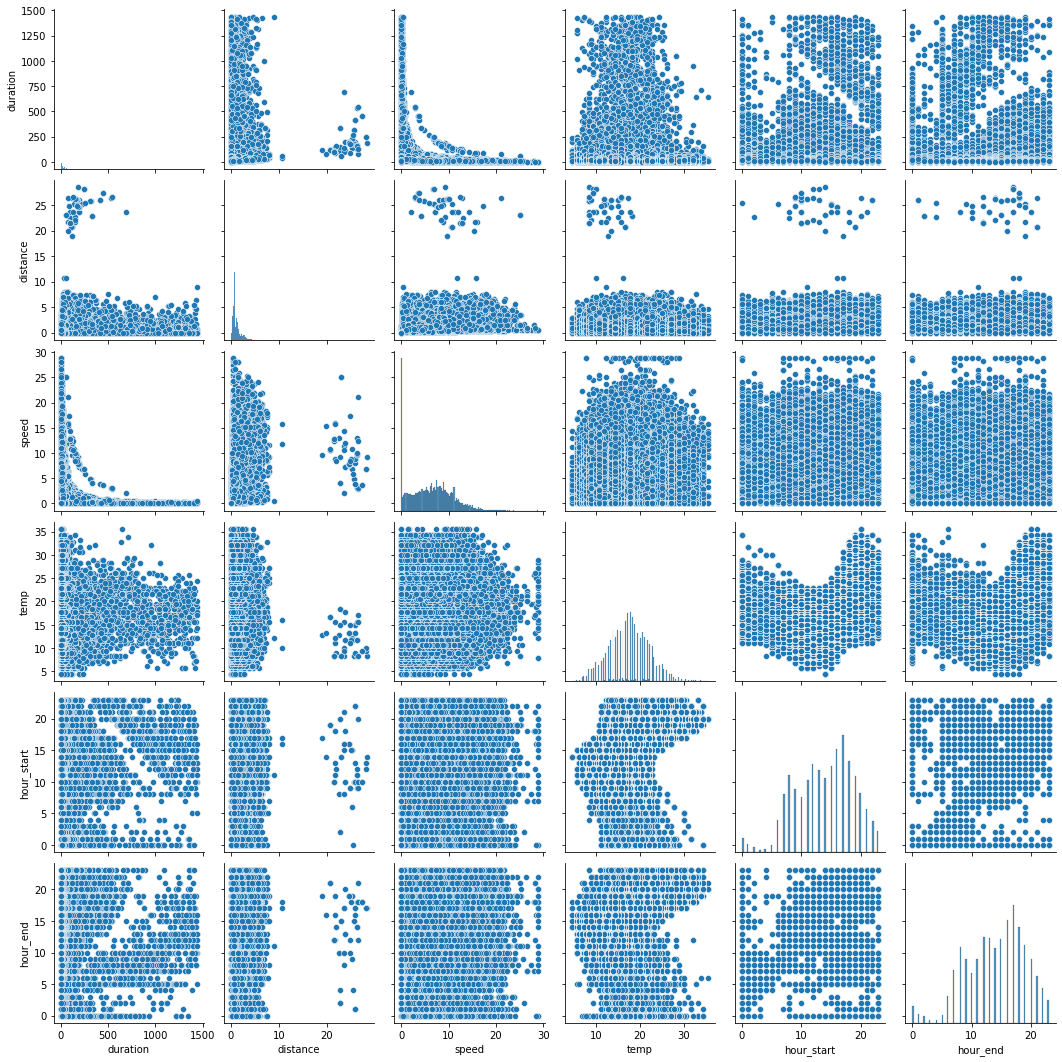

In [12]:
sns.pairplot(data=trips_df.drop(columns=[
    "user_type", "month", "is_weekday", "is_holiday", "start_longitude", "end_longitude", "start_latitude", "end_latitude"]))

Looking at all plots we can recognize some groups that are distinguished:
 - Especially in the feature _distance_ there is a clear cut between long and short trips.
 - In _duration_ to _speed_ we see a little cut between points in the middle and near the axes.
 - Between _duration_ and both _hour_start_ and _hour_end_ there seems to be a linear cut through the data.
 - Comparing _speed_ to other features we see some very fast bike riders in contrast to slower ones.

Let us scale the features so the distances we will compute are in the same range.

In [13]:
X = trips_df
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head(2)

,user_type,duration,start_latitude,start_longitude,end_latitude,end_longitude,distance,speed,temp,hour_start,month,is_weekday,is_holiday,hour_end
210759,-1.408073,0.866421,-4.852621,-6.327361,-4.914277,-6.244778,-1.044772,-1.429291,-0.434428,-2.642843,-1.73688,0.541532,4.753206,-2.429989
210760,-1.408073,0.837004,-4.852621,-6.327361,-4.914277,-6.244778,-1.044772,-1.429291,-0.434428,-2.642843,-1.73688,0.541532,4.753206,-2.429989


## PCA Dimensionality Reduction

Because we have 14 features we try to reduce the dimensionality with a principal component analysis. First we try it with 5 components (~3 features per component).

In [14]:
pca = PCA(n_components=5)
trips_scaled_pca = pca.fit_transform(X_scaled_df)
print(sum(pca.explained_variance_ratio_))

0.640876488002427


Because the explained variance ratio is only about 63% we try reducing the dimensionality to 7 PCA components (2 features per component).

In [15]:
pca = PCA(n_components=7)
trips_scaled_pca = pca.fit_transform(X_scaled_df)
print(sum(pca.explained_variance_ratio_))

0.7807104446746534


Because 78% is still not sufficient for a feature reduction we will run the clustering without reducing the feature dimensionality.

## Algorithm: K-means++

Now we will run the clustering algorithm K-means++ on this data to answer three main questions:
1. Which clusters are found by the algorithm?
2. Are those clusters useful and informative in terms of our business values?
3. Can our cluster assumptions made above be found in the clusters by the algorithm?

We can use the KMeans() Model because scikit learn uses K-means++ by default.

In [16]:
# defining the maximum quantity of centers
k_max = 20

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = KMeans(n_clusters=k + 1, )
    model.fit(X_scaled)
    clusters.append(k + 1)
    losses.append(model.inertia_)

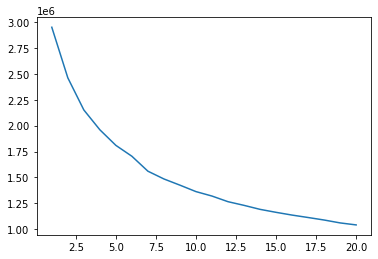

In [17]:
# plot losses
plt.plot(clusters, losses)
plt.show()

(0.0, 10.0)

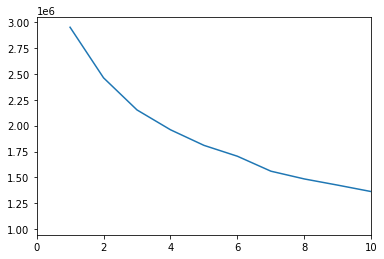

In [18]:
# plot losses more detailed
plt.plot(clusters, losses)
plt.xlim([0, 10])

The loss of course decreases with the quantity of clusters. Because we already have many features we set K=8 as there is an edge in the loss graph. This seems like a reasonable value for our cluster quantity so we will run the model with 8 clusters again and take a closer look. Furthermore we add a random state to our model so it can be recreated with the same cluster-label-numbers.

In [19]:
# run again with k=8
eight_means = KMeans(n_clusters=8, random_state=4711)
eight_means.fit(X_scaled)
eight_means.predict(X_scaled)

array([1, 1, 5, ..., 5, 5, 5], dtype=int32)

In [20]:
# create dataframe with clusters, their size and the means of the features
clusters = eight_means.cluster_centers_
clusters = scaler.inverse_transform(clusters)
clusters_df = pd.DataFrame(clusters, columns=X.columns)
clusters_rounded_df = clusters_df.round(2)
clusters_rounded_df["size"] = X_scaled_df.groupby(eight_means.labels_).size()
clusters_rounded_df.head(10)

,user_type,duration,start_latitude,start_longitude,end_latitude,end_longitude,distance,speed,temp,hour_start,month,is_weekday,is_holiday,hour_end,size
0,0.89,14.99,34.05,-118.25,34.05,-118.25,0.95,6.23,12.58,12.79,2.51,0.90,-0.00,12.97,36233
1,0.30,59.94,34.00,-118.48,34.00,-118.48,1.04,2.62,10.97,13.33,1.38,0.64,0.09,14.19,3853
2,0.97,18.58,34.05,-118.26,34.05,-118.26,0.51,3.10,19.54,16.76,8.16,1.00,-0.00,16.91,45299
3,0.88,24.46,34.05,-118.26,34.05,-118.26,0.91,4.35,18.57,15.60,7.55,-0.00,-0.00,15.80,34744
4,0.69,827.35,34.05,-118.27,34.05,-118.27,1.23,0.10,18.03,14.43,6.45,0.68,0.04,9.97,1068
5,0.88,17.34,34.05,-118.26,34.05,-118.26,1.02,5.95,17.30,14.25,7.24,0.81,1.00,14.44,8545
6,0.95,12.45,34.05,-118.26,34.05,-118.25,1.88,10.39,20.18,17.60,7.77,0.95,0.00,17.73,34456
7,1.01,11.14,34.05,-118.25,34.05,-118.25,1.15,8.07,17.52,7.87,8.34,0.91,-0.00,8.01,46440


In the table showing the centers we can already see some interesting points. For example the long duration in cluster 7 or only holiday trips in cluster 6. We will now take a closer look at all clusters.

### 1. Which clusters are found by the algorithm?

Now we will analyse each cluster to label it.

In [21]:
# map cluster to data
X["cluster"] = eight_means.labels_

In [22]:
# function for plotting comparing clusters in different features
def show_cluster_values(columns):
    fig, axs = plt.subplots(int(len(columns) / 2), 2)
    fig.set_size_inches(10, 10)
    plots_row = 0
    plots_col = 0
    for col in columns:
        sns.violinplot(
            x=X["cluster"],
            y=X[col],
            data=X,
            palette="magma",
            ax=axs[plots_row][plots_col],
        )
        if plots_col == 1:
            plots_row = plots_row + 1
            plots_col = 0
        else:
            plots_col = 1
    plt.tight_layout()


First we take a look at the location data.

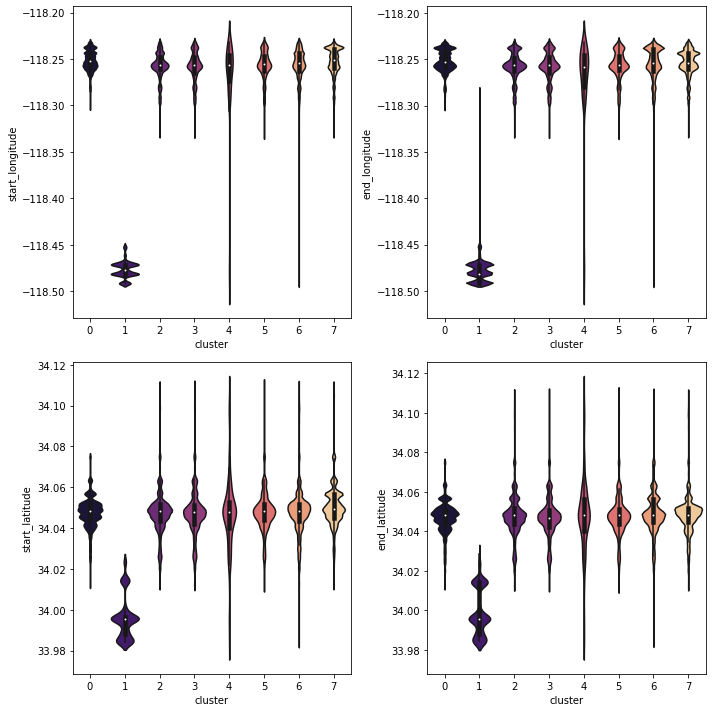

In [23]:
show_cluster_values(
    ["start_longitude", "end_longitude", "start_latitude", "end_latitude"]
)


On the left side are both start values and on the right the end values. This is the analysis:
- longitude: Nearly all trips that happen in a low longitude (aka in the east) are in cluster 2. Those in the middle are in cluster 3. All other clusters are equally distributed in the west of the city whereas very few trips in cluster 6 and 7 also end in the east.
- latitude: All trips of cluster 3 are driven in the north at a higher latitude. Cluster 2 trips are more in the south. The other clusters are distributed over the middle.

All in all the locational differences can be seen in different clusters.

Now we want to analyse the features that are time related:

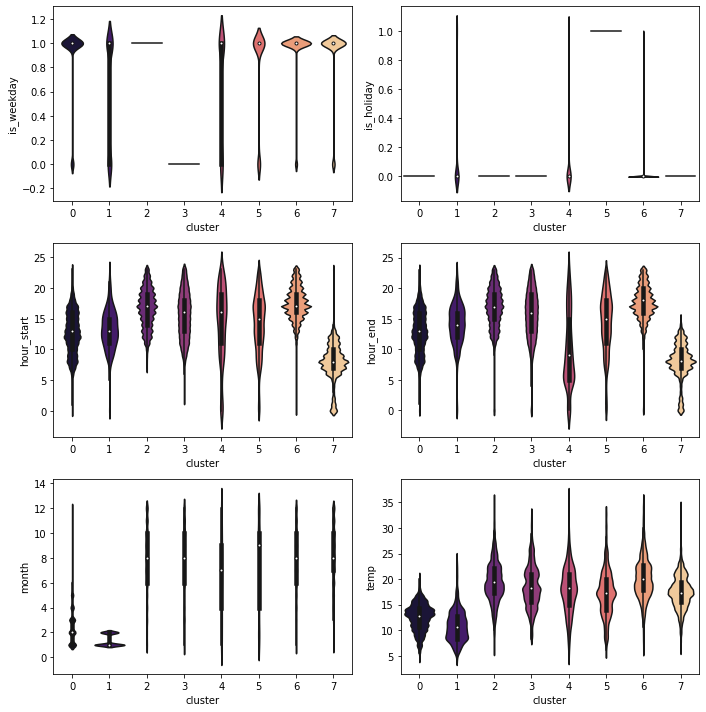

In [24]:
show_cluster_values(
    ["is_weekday", "is_holiday", "hour_start", "hour_end", "month", "temp"]
)


- is_weekday: Cluster 5 describes only weekend trips. The other clusters have both kinds of trips in their data.
- is_holiday: Cluster 6 describes only holiday trips. Most other trips are not on holidays even though few holiday trips can be found in cluster 2,3, and 7.
- hour_start and hour_end: Most evening trips are in cluster 4 whereas many trips in the morning and around noon are in cluster 0. The other cluster times are distributed over the day.
- month: Cluster 2 only describes winter months in the beginning of the year while cluster 3 has trips from august to december. Cluster 7 are mainly summer months.
- temp: With more winter trips in clusters 1 and 2 the temperatures are lower in those clusters than in the other ones.

Now we will take a look at the rest of the features:

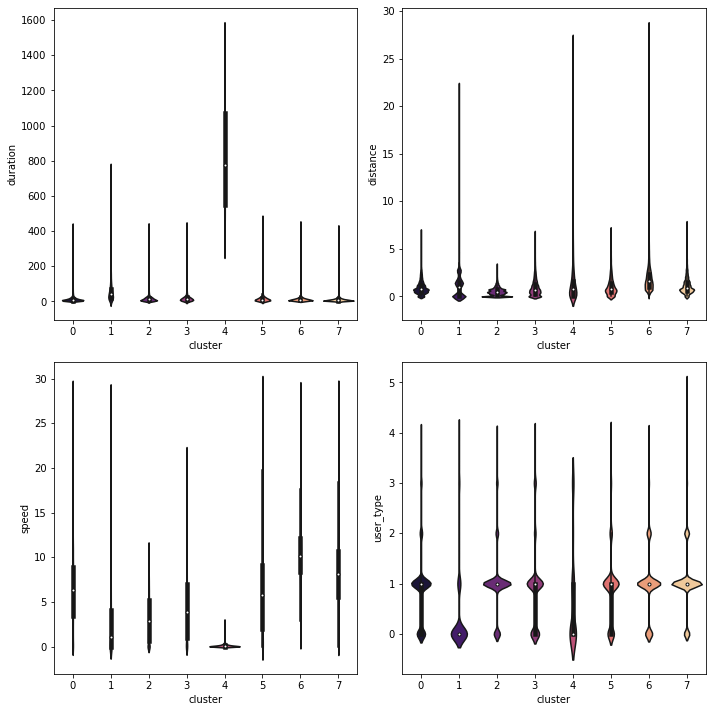

In [25]:
show_cluster_values(["duration", "distance", "speed", "user_type"])

- duration, speed: Cluster 7 has all long trips in terms of duration. Those trips are also the slowest ones.
- distance: There are long distances in cluster 2, 6 and 7 but most trips have short distances.
- user_type: Most users are type 1. In cluster 2 there is a high amount of user-type 0 trips.

If we sum up our findings we can label the clusters as such:
- Cluster 0: west, morning and noon  - **morning**
- Cluster 1: west, low temp - **low temperature**
- Cluster 2: east, south, winter beginning of year, low temp, user type 0  - **south-east**
- Cluster 3: north, august to december - **north**
- Cluster 4: west, evening and night- **evening**
- Cluster 5: west, weekend - **weekend**
- Cluster 6: west, holiday - **holiday**
- Cluster 7: west, summer, long trips, slow trips - **long summer trips**

In [26]:
labels = [
    "morning",
    "low temperature",
    "south-east",
    "north",
    "evening",
    "weekend",
    "holiday",
    "long summer trips",
]

X["label"] = X["cluster"].apply(lambda x: labels[x])
X.head()


,user_type,duration,start_latitude,start_longitude,end_latitude,end_longitude,distance,speed,temp,hour_start,month,is_weekday,is_holiday,hour_end,cluster,label
210759,0,80.0,33.98493,-118.46996,33.98493,-118.46996,0.000000,0.000000,15.6,1,1,1,1,2,1,low temperature
210760,0,78.0,33.98493,-118.46996,33.98493,-118.46996,0.000000,0.000000,15.6,1,1,1,1,2,1,low temperature
55231,0,4.0,34.04998,-118.24716,34.05287,-118.24749,0.156355,2.345331,15.6,1,1,1,1,1,5,weekend
150266,0,37.0,34.04554,-118.25667,34.02030,-118.28118,3.030349,4.914079,15.6,1,1,1,1,2,5,weekend
150267,0,36.0,34.04554,-118.25667,34.02030,-118.28118,3.030349,5.050581,15.6,1,1,1,1,2,5,weekend


### 2. Are those clusters useful and informative in terms of our business values?

Some of the clusters are useful for information about the bikesharing business. We can map new trips into these clusters and predict similarities. We could also create new pricing models by these clusters. For example a special summer package for long trips which the users in the _long summer trips_ cluster drive or a ticket which is only valid in one of the 3 main areas west, south-east and north. Another idea would be to have special weekend and holiday prices.
The special packages, tickets and prices could be recommended to customers who have most of their trips in specific clusters.


### 3. Can our cluster assumptions made above be found in the clusters by the algorithm?

For this question we plot our assumption above in 2D again:

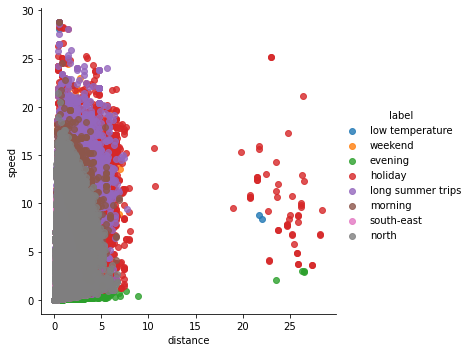

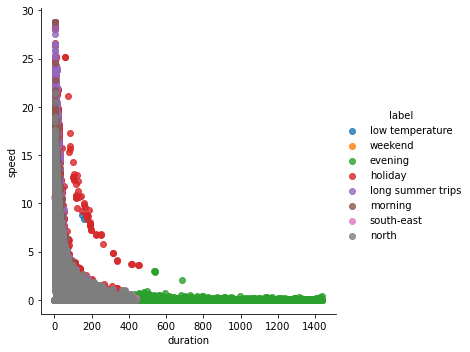

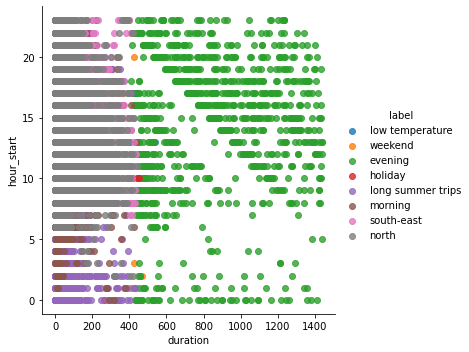

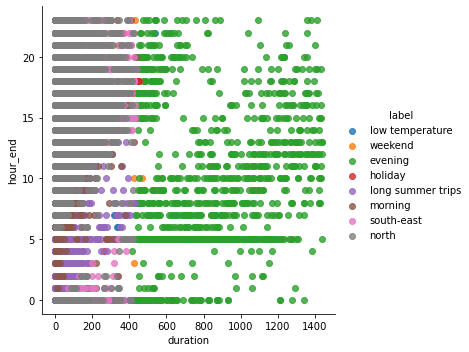

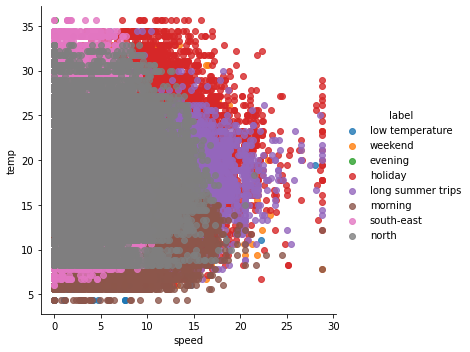

In [27]:
sns.lmplot(x="distance", y="speed", data=X, fit_reg=False, hue="label")
sns.lmplot(x="duration", y="speed", data=X, fit_reg=False, hue="label")
sns.lmplot(x="duration", y="hour_start", data=X, fit_reg=False, hue="label")
sns.lmplot(x="duration", y="hour_end", data=X, fit_reg=False, hue="label")
sns.lmplot(x="speed", y="temp", data=X, fit_reg=False, hue="label")

 - distance -> all: Longer trips are mostly in the south-east cluster whereas north trips are rather short. Our assumption that the clustering would distinguish long and short trips can be seen.
 - duration -> speed: As with the distance in the plot above the smaller group of points here are mostly south-east trips. We can see different clusters in different groups here too.
 - duration -> hour_start and hour_end: Here the data points are very mixed and the linear cut does not distinguish clusters.
 - speed -> temp: Here we can see a cut between different clusters from inner to outer but not between very fast riders and slower ones.

All in all the first 2 assumption were also found by our K-means++ algorithm whereas our 3rd and 4th assumption was not validated.